# Effects of Domain in the GS Model

By keeping all paramters constant and initial conditions consistent as a centered cluster of ones in the activator component matrix (modeled by V in the GS model), we visualized the evolution of pattern with ADI method for different domains.

We chose to use ADI method to compute the solution for the PDE equations since it is comparatively the most accurate (2-nd order) and the most stable (allows the largest dt) among all the 4 methods we tried.

## Experiments Parameters Setup

### Varied Domain 
```python
Ny_list = [8, 16, 24, 32, 40, 48, 56, 64] # varied length of the y-direction of the grid
```
### Other Controled Conditions
```python
Nx = 64 # length of the x-direction side of the entire grid
h = 2 # space step size, same in x and y direction
N = Nx * Ny # 1D length of the entire grid

Du = 1.0 # diffusion rate of u
Dv = 0.5 # diffusion rate of v
ff = 0.055 # feed rate, same as 'f' in the model PDE equation
kk = 0.062 # kill rate, same as 'k' in the model PDE equation

dt = 1.5 # time step size for ADI
end_t = 10000 # end time
time_steps = int(end_t / dt) # number of time steps of the entire evolution

U_init[:, :] = 1 # initial condition for u: all 1
V_init[24:40, 24:40] = 1 # initial condition for v: a centered cluster of 1's
```

In [1]:
# import libraries
import numpy as np
from util import *
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
from IPython.display import HTML
%matplotlib inline

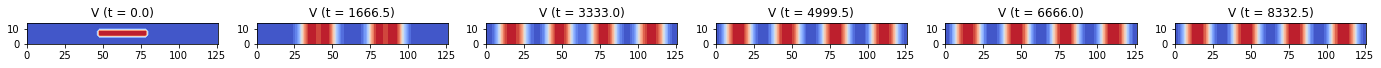

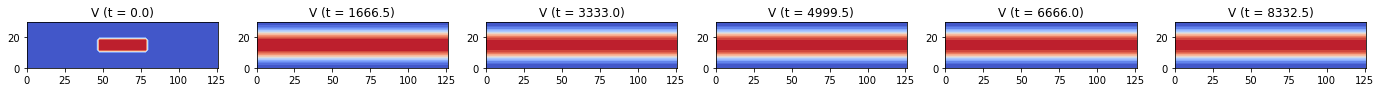

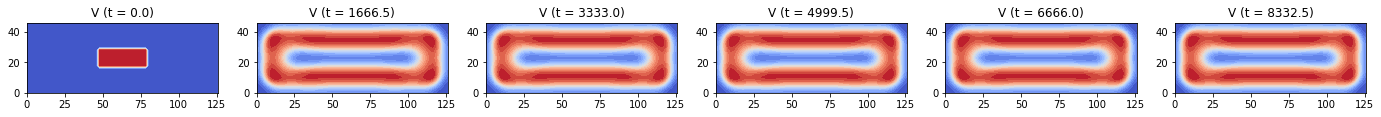

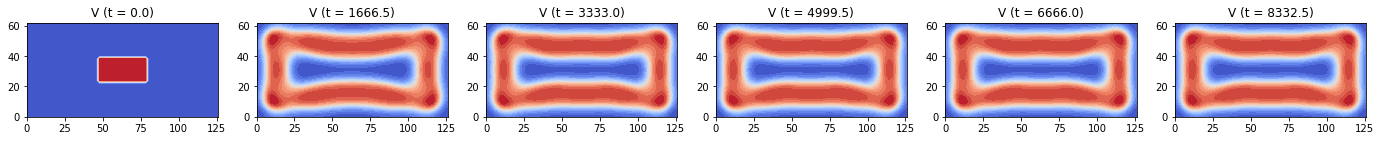

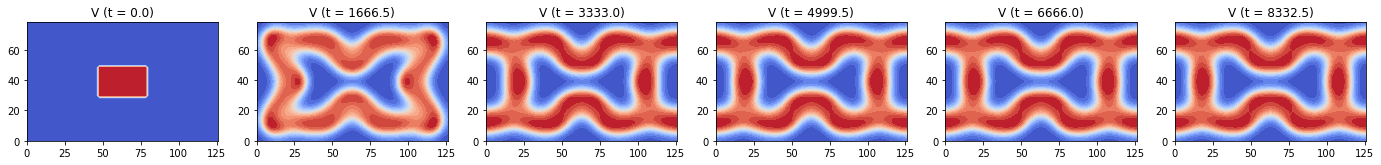

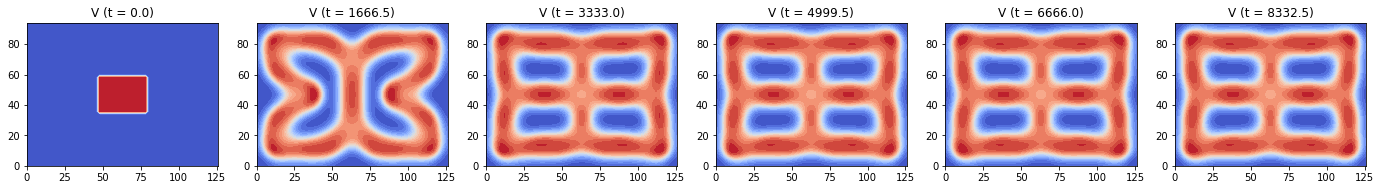

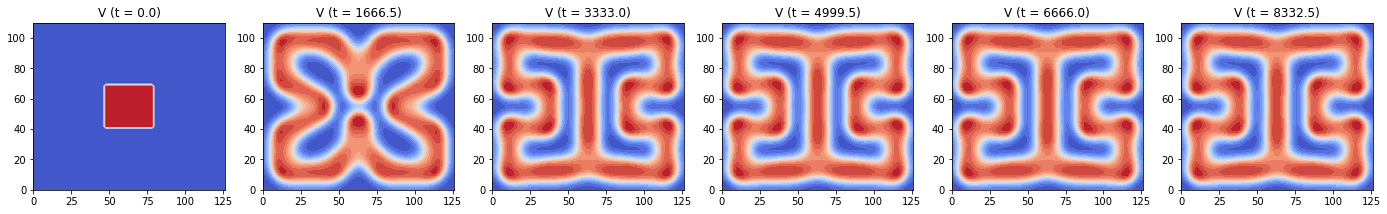

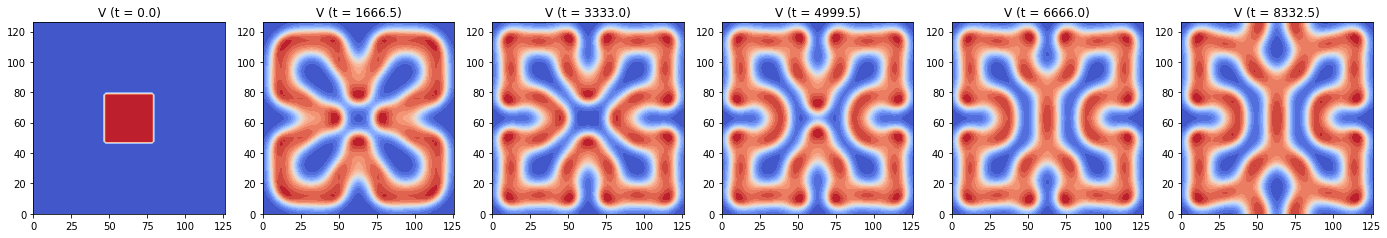

In [2]:
# Grid setup
Ny_list = [8, 16, 24, 32, 40, 48, 56, 64]
Nx = 64
h = 2

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1.5
end_t = 10000
time_steps = int(end_t / dt)
c = dt / (h * h)

for Ny in Ny_list:
    # Construct transform matrices
    D2x = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Nx, -1 + Nx], shape=(Nx, Nx))
    D2y = sparse.diags([-2, 1, 1, 1, 1], [0, 1, -1, 1 - Ny, -1 + Ny], shape=(Ny, Ny))
    Tu_x = sparse.eye(Nx) - 0.5 * Du * c * D2x
    Tu_y = sparse.eye(Ny) - 0.5 * Du * c * D2y
    Tv_x = sparse.eye(Nx) - 0.5 * Dv * c * D2x
    Tv_y = sparse.eye(Ny) - 0.5 * Dv * c * D2y

    # Factorize matrices
    solve_Tu_x = linalg.factorized(Tu_x.tocsc())
    solve_Tu_y = linalg.factorized(Tu_y.tocsc())
    solve_Tv_x = linalg.factorized(Tv_x.tocsc())
    solve_Tv_y = linalg.factorized(Tv_y.tocsc())

    # Initial condition
    U_init = np.zeros((Ny, Nx))
    V_init = np.zeros((Ny, Nx))
    U_init[:, :] = 1

    j_0 = int(3/8*Ny)
    j_1 = int(5/8*Ny)
    k_0 = int(3/8*Nx)
    k_1 = int(5/8*Nx)
    V_init[j_0:j_1, k_0:k_1] = 1

    U = np.zeros((time_steps, Ny, Nx))
    V = np.zeros((time_steps, Ny, Nx))
    U[0] = np.copy(U_init)
    V[0] = np.copy(V_init)

    # Generate pattern
    for i in range(1, time_steps):
        # Stage one - solve along x direction
        b1U = 0.5 * Du * c * D2y.dot(U[i - 1]) \
            + (1 - 0.5 * dt * V[i - 1] ** 2 - 0.5 * dt * ff) * U[i - 1] + 0.5 * dt * ff
        b1V = 0.5 * Dv * c * D2y.dot(V[i - 1]) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V[i - 1] + 0.5 * dt * U[i - 1] * V[i - 1] ** 2

        U_middle = solve_Tu_x(b1U.T)
        V_middle = solve_Tv_x(b1V.T)

        # Stage two - solve along y direction
        b2U = 0.5 * Du * c * D2x.dot(U_middle) \
            + (1 - 0.5 * dt * V_middle ** 2 - 0.5 * dt * ff) * U_middle + 0.5 * dt * ff
        b2V = 0.5 * Dv * c * D2x.dot(V_middle) \
            + (1 - 0.5 * dt * kk - 0.5 * dt * ff) * V_middle + 0.5 * dt * U_middle * V_middle ** 2

        U[i] = solve_Tu_y(b2U.T)
        V[i] = solve_Tv_y(b2V.T)

    plot_pattern_evolution(V, h, dt, time_steps, name='V', r=1, Nout=6)


## Summary
As visualized above, as we increase the length of the y-direction side of the gird, we saw patterns modeled by the GS model's activator component (V) as 

- vertical stripes against the x-direction,
- parallel stripes to the x-direction, 
- simple rectangular patterns, 
- and more complicated rectangular patterns. 

This corresponds to Murray's claim on the pattern of animal tails that **narrow domains** allow only bands to grow while **large domains** allow spots or more complicated pattern to form.